In [1]:
import scanpy as sc

In [2]:
import glob
import os
import numpy as np

import seaborn as sns

import pandas as pd
import scipy.stats
import tqdm
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [3]:
import gc

## Read adata

In [5]:
data_path = 'tmp'
motif_path = os.path.join(data_path, 'motif_deletion/')

In [7]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad'))

## Read ref and alternative

In [10]:
alts = pd.Series([x for x in glob.glob(f'{motif_path}*multiome_fixed.h5ad') if 'ref_multiome' not in x and "atac" not in x and 'rna' not in x])

In [13]:
ad_ref = sc.read(os.path.join(motif_path, 'ref_multiome_fixed.h5ad'))

In [14]:
ad_ref = ad_ref[adata.obs_names]

In [17]:
gene_set_to_run = ad_ref.var_names

In [19]:
median_sf=np.median(ad_ref.X.sum(axis=1))

In [20]:
sc.pp.normalize_total(ad_ref, target_sum=median_sf, key_added='size_factor')

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
diff_rna = {}
diff_atac = {}
norm_factor = ad_ref.obs['size_factor'].values[:, None]
for i, alt in tqdm.tqdm(enumerate(alts)):
    ad_alt = sc.read(alt)
    motif_name = os.path.basename(alt).split('alt_')[1].split('_multiome_fixed.h5ad')[0]
    ad_alt = ad_alt[adata.obs_names, list(gene_set_to_run)]

    ad_alt.X = ad_alt.X/norm_factor * median_sf

    motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()
    diff_rna.update({motif_name: motif_rna})
    del ad_alt
    gc.collect()

0it [00:00, ?it/s]

Only considering the two last: ['.B_multiome_fixed', '.h5ad'].
Only considering the two last: ['.B_multiome_fixed', '.h5ad'].


84it [00:08, 10.39it/s]


In [95]:
diff_rna = pd.DataFrame(diff_rna, index=ad_ref.obs_names)
diff_rna.columns = diff_rna.columns + '.' + diff_rna.columns

In [97]:
dev = sc.read(os.path.join(data_path, 'eval/chromvar/deviations.h5ad'))

## Plot overall correlations

In [98]:
dev = dev[diff_rna.index, diff_rna.columns]

In [103]:
new_names_tf = {
    'TYY1': "YY1", 
    'STA5B':"STAT5B",
     'KAISO':"ZBTB33", 
    'STA5A': "STAT5A", 
    'COE1':"EBF1"
}

In [104]:
tf = dev.var_names.str.split('.').str[0].to_list()

In [105]:
tf = pd.Series([tf_i if tf_i not in new_names_tf.keys() else new_names_tf[tf_i] for tf_i in tf])

In [106]:
dev.var['TF'] = tf.values

/scratch/tmp/hingerl/ipykernel_1845498/3195176874.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dev.var['TF'] = tf.values


In [110]:
diff_rna = diff_rna.loc[adata.obs_names]

In [113]:
expression_corr_norm = [scipy.stats.pearsonr(diff_rna[motif].values, adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

In [115]:
expression_chromvar_norm = [scipy.stats.pearsonr(dev[:, motif].X.squeeze(), adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

FOS
FOSB
FOSL2


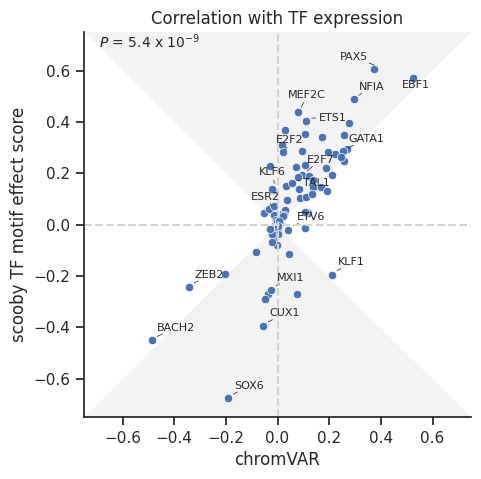

In [119]:
fig, ax = plt.subplots(figsize=(5,5))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.scatterplot(x=expression_chromvar_norm, y=expression_corr_norm, ax=ax)

plt.axvline(0, linestyle ='--', color = 'lightgray')
plt.axhline(0, linestyle ='--', color = 'lightgray')

triangle = np.array([[0., 0.], [-1., 1.], [1, 1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

triangle = np.array([[0., 0.], [-1., -1.], [1, -1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

zipped = zip(expression_chromvar_norm, expression_corr_norm)
adj_text = []
for i, (x,y) in enumerate(zipped):
    name= tf.iloc[i]
    if (((x**2 + y**2) > 0.15) and name not in ['CEBPD',  'FOSL2', 'FOSB', 'RUNX2', 'MAFF', 'FOS', 'CREB5', 'KLF2', 'SOX5', 'JDP2', 'TFEC']) or name in ['ESR2', 'KLF6', 'E2F2', 'TAL1', 'MXI1', 'ETV6', 'GATA1', 'E2F7', 'KLF1', 'ZEB2'] : #or str(point['val']) in ['SOX13', 'FOSB', 'TEAD2',  'FLI1', 'FOXP1']:
        if name == 'COE1':
            name = 'EBF1'
        adj_text.append(ax.text(x + 0.01, y+0.01 , "" + f"{name}" +"", size= 8))
adjust_text(adj_text, expand=(2.2, 2.0), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='k', lw = 0.5) # ensure the labeling is clear by adding arrows
            );
ax.text(-0.69,0.69, r'$P$ = 5.4 x $10^{-9}$', size = 10)
#plt.legend([],[], frameon=False)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.title('Correlation with TF expression')
plt.xlabel("chromVAR")
plt.ylabel("scooby TF motif effect score")
sns.despine()
plt.savefig('../figures/figures/Figure3/chromVAR_scDogRNA.png',  bbox_inches='tight', dpi = 300)

## scDog RNA only

In [120]:
alts = pd.Series([x for x in glob.glob(f'{motif_path}*rnaonly_fixed.h5ad') if 'ref_rnaonly' not in x and "atac" not in x])

In [123]:
ad_ref = sc.read(os.path.join(motif_path, 'ref_rnaonly_fixed.h5ad'))

In [124]:
ad_ref = ad_ref[adata.obs_names]

In [128]:
median_sf=np.median(ad_ref.X.sum(axis=1))

In [129]:
sc.pp.normalize_total(ad_ref, target_sum=median_sf, key_added='size_factor')

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [130]:
diff_rna = {}
diff_atac = {}
norm_factor = ad_ref.obs['size_factor'].values[:, None]
for i, alt in tqdm.tqdm(enumerate(alts)):
    ad_alt = sc.read(alt)
    motif_name = os.path.basename(alt).split('alt_')[1].split('_rnaonly_fixed.h5ad')[0]
    ad_alt = ad_alt[adata.obs_names, list(gene_set_to_run)]

    ad_alt.X = ad_alt.X/norm_factor * median_sf

    motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()

    diff_rna.update({motif_name: motif_rna})
    del ad_alt
    gc.collect()

0it [00:00, ?it/s]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


1it [00:08,  8.62s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


2it [00:16,  8.20s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


3it [00:24,  8.12s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


4it [00:32,  7.99s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


5it [00:40,  8.05s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


6it [00:48,  7.94s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


7it [00:56,  7.92s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


8it [01:03,  7.90s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


9it [01:12,  7.98s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


10it [01:20,  8.06s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


11it [01:28,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


12it [01:36,  7.98s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


13it [01:44,  7.97s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


14it [01:52,  8.07s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


15it [02:00,  8.11s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


16it [02:08,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


17it [02:16,  8.04s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


18it [02:24,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


19it [02:32,  7.98s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


20it [02:40,  7.93s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


21it [02:48,  7.91s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


22it [02:55,  7.89s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


23it [03:03,  7.88s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


24it [03:11,  7.83s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


25it [03:19,  7.88s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


26it [03:27,  7.84s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


27it [03:34,  7.80s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


28it [03:42,  7.86s/it]

Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].


29it [03:51,  7.97s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


30it [03:58,  7.95s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


31it [04:06,  7.87s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


32it [04:14,  7.90s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


33it [04:22,  7.97s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


34it [04:31,  8.07s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


35it [04:38,  7.96s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


36it [04:46,  7.97s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


37it [04:54,  7.99s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


38it [05:02,  7.90s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


39it [05:10,  8.05s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


40it [05:18,  7.96s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


41it [05:27,  8.16s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


42it [05:35,  8.15s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


43it [05:43,  8.14s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


44it [05:51,  8.03s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


45it [05:59,  7.99s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


46it [06:07,  7.98s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


47it [06:15,  8.03s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


48it [06:23,  7.95s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


49it [06:30,  7.93s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


50it [06:39,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


51it [06:47,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


52it [06:55,  7.98s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


53it [07:02,  7.94s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


54it [07:10,  7.95s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


55it [07:18,  7.93s/it]

Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].


56it [07:27,  8.06s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


57it [07:34,  7.97s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


58it [07:43,  8.10s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


59it [07:51,  8.10s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


60it [07:59,  8.04s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


61it [08:07,  8.13s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


62it [08:15,  8.06s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


63it [08:23,  8.17s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


64it [08:31,  8.07s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


65it [08:39,  8.03s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


66it [08:47,  8.05s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


67it [08:55,  8.02s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


68it [09:03,  8.02s/it]

Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].


69it [09:11,  8.02s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


70it [09:19,  8.02s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


71it [09:27,  7.97s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


72it [09:35,  8.03s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


73it [09:43,  8.04s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


74it [09:52,  8.09s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


75it [09:59,  8.00s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


76it [10:07,  7.92s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


77it [10:15,  7.97s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


78it [10:23,  7.92s/it]

Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.A_rnaonly_fixed', '.h5ad'].


79it [10:32,  8.13s/it]

Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.C_rnaonly_fixed', '.h5ad'].


80it [10:40,  8.08s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


81it [10:47,  7.97s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


82it [10:55,  7.98s/it]

Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].
Only considering the two last: ['.B_rnaonly_fixed', '.h5ad'].


83it [11:04,  8.00s/it]


In [131]:
diff_rna = pd.DataFrame(diff_rna, index=ad_ref.obs_names)
diff_rna.columns = diff_rna.columns + '.' + diff_rna.columns

In [148]:
diff_rna = diff_rna.loc[adata.obs_names]

In [149]:
assert (dev.var_names == diff_rna.columns).all()

In [151]:
expression_corr_norm = [scipy.stats.pearsonr(diff_rna[motif].values, adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

In [153]:
expression_chromvar_norm = [scipy.stats.pearsonr(dev[:, motif].X.squeeze(), adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

FOS
FOSB
FOSL2


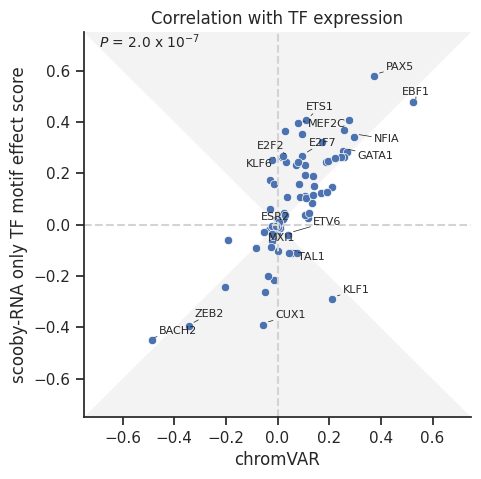

In [81]:
fig, ax = plt.subplots(figsize=(5,5))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.scatterplot(x=expression_chromvar_norm, y=expression_corr_norm, ax=ax)

plt.axvline(0, linestyle ='--', color = 'lightgray')
plt.axhline(0, linestyle ='--', color = 'lightgray')

triangle = np.array([[0., 0.], [-1., 1.], [1, 1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

triangle = np.array([[0., 0.], [-1., -1.], [1, -1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

zipped = zip(expression_chromvar_norm, expression_corr_norm)
adj_text = []
for i, (x,y) in enumerate(zipped):
    name= tf.iloc[i]

    if (((x**2 + y**2) > 0.15) and name not in ['CEBPD',  'FOSL2', 'FOSB', 'RUNX2', 'MAFF', 'FOS', 'CREB5', 'KLF2', 'SOX5', 'JDP2', 'TFEC']) or name in ['ESR2', 'KLF6', 'E2F2', 'TAL1', 'MXI1', 'ETV6', 'GATA1', 'E2F7', 'KLF1', 'ZEB2'] : #or str(point['val']) in ['SOX13', 'FOSB', 'TEAD2',  'FLI1', 'FOXP1']:
        if name == 'COE1':
            name = 'EBF1'
        adj_text.append(ax.text(x + 0.01, y+0.01 , "" + f"{name}" +"", size= 8))
adjust_text(adj_text, expand=(2.2, 1.9), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='k', lw = 0.5) # ensure the labeling is clear by adding arrows
            );

ax.text(-0.69,0.69, r'$P$ = 2.0 x $10^{-7}$', size = 10)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.title('Correlation with TF expression')
plt.xlabel("chromVAR")
plt.ylabel("scooby-RNA only TF motif effect score")
sns.despine()
plt.savefig('../figures/figures/Figure3/chromVAR_scDogRNA_RNAonly.png',  bbox_inches='tight', dpi = 300)